# "No Regrets"
## A word vector analysis of Game of Thrones
following Siraj's example following Yuriy Guts' example

### Generating and analyzing word vectors from novels

---

In [1]:
########## IMPORT DEPENDENCIES ##########
# allows to use both Python 2 and 3 syntax
from __future__ import absolute_import, division, print_function
# for word encoding we
import codecs
# and of course for any NLP we'll need regex:
import re
# but seems we'll also be using a different library for this
import glob
# concurrency, in order to process the data more efficiently
import multiprocessing
# dealing with the OS, like reading a file
import os
# for niceness
from pprint import pprint
# for any sorts of NLP analysis
import nltk
# AAAAAND: WORD 2 VEC!! (the star of the show)
# a google trained a NN on a huge set of word vectors;
# it's a generalized collection of word vectors (=tha shit!)
import gensim.models.word2vec as w2v
# for dimensionality reduction for our puny brains
# bc the wv are gonna be 300+ dimensions
import sklearn.manifold
# for math
import numpy as np
import pandas as pd
# and plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
########## CLEAN DATA ##########
from nltk.tokenize import punkt
from nltk.corpus import stopwords

In [4]:
book_filenames = sorted(glob.glob(r'data/*.txt'))
print(book_filenames)

['data/got1.txt', 'data/got2.txt', 'data/got3.txt', 'data/got4.txt', 'data/got5.txt']


### Making one large opus (that's what it is anyways)

In [5]:
# using UTF-8 as the common format for all texts
corpus_raw = u""
# adding a fake count for amount of people in the books
# just because GoT and there are so many deaths. ;)
fun_count = 300
for book_filename in book_filenames:
    print("Leisurely skimming '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book:
        corpus_raw += book.read()
    fun_count -= 50
    print("Read {0} characters of text, found ~{1} plot characters...".format(len(corpus_raw), fun_count))
    print()
print("Whoa!... Okay peepz. Spoiler Alert! ...")

Leisurely skimming 'data/got1.txt'...
Read 1770659 characters of text, found ~250 plot characters...

Leisurely skimming 'data/got2.txt'...
Read 4071041 characters of text, found ~200 plot characters...

Leisurely skimming 'data/got3.txt'...
Read 6391405 characters of text, found ~150 plot characters...

Leisurely skimming 'data/got4.txt'...
Read 8107945 characters of text, found ~100 plot characters...

Leisurely skimming 'data/got5.txt'...
Read 9719485 characters of text, found ~50 plot characters...

Whoa!... Okay peepz. Spoiler Alert! ...


### Tokenize the corpus

In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
raw_sents = tokenizer.tokenize(corpus_raw)

In [8]:
def sentence_to_wordlist(raw):
    """replace all non-alpha chars with a space, then split the text."""
    # tr -sc 'a-zA-Z' ' ' < GoT_corpus.txt 😉
    clean = re.sub(r"[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words

In [9]:
# awesome stuff with list comprehension
# tokenize each word in each sentence
sentences = [sentence_to_wordlist(s) for s in raw_sents if len(raw_sents) > 0]

In [10]:
sent_num = 11

print(raw_sents[sent_num])
print(sentence_to_wordlist(raw_sents[sent_num]))

Their droppings speckled the gargoyles that rose twelve feet tall on either side of him, a hellhound and a wyvern, two of the thousand that brooded over the walls of the ancient fortress.
['Their', 'droppings', 'speckled', 'the', 'gargoyles', 'that', 'rose', 'twelve', 'feet', 'tall', 'on', 'either', 'side', 'of', 'him', 'a', 'hellhound', 'and', 'a', 'wyvern', 'two', 'of', 'the', 'thousand', 'that', 'brooded', 'over', 'the', 'walls', 'of', 'the', 'ancient', 'fortress']


In [11]:
# count the amount of word tokens in the corpus
token_count = sum([len(sentence) for sentence in sentences])

In [12]:
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


Once we have vectors, we have three main tasks we want to perform:
- DISTANCE
- SIMILARITY
- RANKING

(e.g. scan all scientific papers and figure out which has the highest ranking regarding having the most information about climate change! Exciting!)

In [13]:
# define the dimensionality of the word vectors.
# higher dimensionality makes them more computationally expensive to train
# but also more accurate
# GENERALLY: more dimensions = more generalized
num_features = 300

# smallest set that we want to recognize when converting to a vector
min_word_count = 3

# number of threads to run in parallel
# the more workers we have, the faster we can train
num_workers = multiprocessing.cpu_count()

# context window size (how many words looked at in one peek)
context_window = 7

# downsample setting for frequent words
# 0 - 1e-5 is good for this
# essentially it means that we don't want to look at words that appear too frequently too frequently
# how often do we look at a word - the more frequent, the less often we want to look at it
downsampling = 1e-3

# seed for the random number generator (RNG)
# to make the results reproducible
# the seed makes sure that it is deterministic - which is useful for debugging
seed = 1

In [14]:
# using gensim library for creating the model
# https://radimrehurek.com/gensim/models/word2vec.html
thrones2vec = w2v.Word2Vec(
    sg = 1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_window,
    sample = downsampling
)

In [15]:
# building the model
thrones2vec.build_vocab(sentences)

In [16]:
print("Word2Vec vocabulary length: {}".format(len(thrones2vec.vocab)))

Word2Vec vocabulary length: 17277


### Train the model

In [17]:
thrones2vec.train(sentences)

7021241

### Saving it to a file for later use

In [19]:
# create a folder for the files
if not os.path.exists("trained"):
    os.makedirs("trained")
    
# save the output of the trained model to a file
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

## Exploration time!

In [20]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

So these are 300-dimensional word vectors, we'll need to apply some dimensionality reduction in order to be able to plot them into 2-dimensional space.

### Compressing into 2D space for visualization

In [21]:
# using t-SNE (t-distributed Stochastic Neighbor Mapping)
# for squashing the dimensions of our data in order to be able to visualize it
# here we choose a 2D representation
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
# assigning a variable to the big matrix holding all the word vectors
# 'syn0' is the feature matrix generated by gensim
all_word_vec_matrix = thrones2vec.syn0

### Training t-SNE
Have to learn about why this is "training" here

In [23]:
all_word_vec_matrix_2D = tsne.fit_transform(all_word_vec_matrix)

Training t-SNE (the dimensionality reduction) took my MacBook Air about 10-15 minutes. And it got its fans spinning... I guess I'll have to look into AWS if I want to do more DL!

## Plotting interesting relationships
Here we go!

In [30]:
# let's first explore the data structure that I just created
# bc of Python 3 I need to explicitly convert the dict_keys object to a list for slicing
list(thrones2vec.vocab.keys())[:5]

['flies', 'crows', 'Daughters', 'shudder', 'uselessly']

In [34]:
# this returns me the coordinates of the word in vector space
# EXCITING!!! :D
all_word_vec_matrix_2D[thrones2vec.vocab["flies"].index]

array([-0.4127513, -3.5300494])

In [40]:
word_points = pd.DataFrame(
    # creating a list (=array-like object for inputing to the df)
    [
        # the list will contain a 3-d-tuple consisting of the word and it's x and y coordinates
        # so here I'm basically saying "make this"
        (word, coords[0], coords[1])
            # from these
            for word, coords in [
                # that we can find here (check the above cell for more info)
                (word, all_word_vec_matrix_2D[thrones2vec.vocab[word].index])
                     # which again we find here in the vocab list:
                     for word in thrones2vec.vocab
        ]
    ],
    # name the columns understandably
    columns = ["word", "x", "y"]
)
# phu, that's quite some list comprehension!! Let's get it going...

In [41]:
# checking it out:
word_points.head()

,word,x,y
0,flies,-0.412751,-3.530049
1,crows,2.067844,0.817775
2,Daughters,0.341622,2.830936
3,shudder,-4.848984,1.635783
4,uselessly,0.481584,-2.563986


In [42]:
# this defines the plotting context, and we want a biiiiiig (posterlike) plot!
sns.set_context("poster")

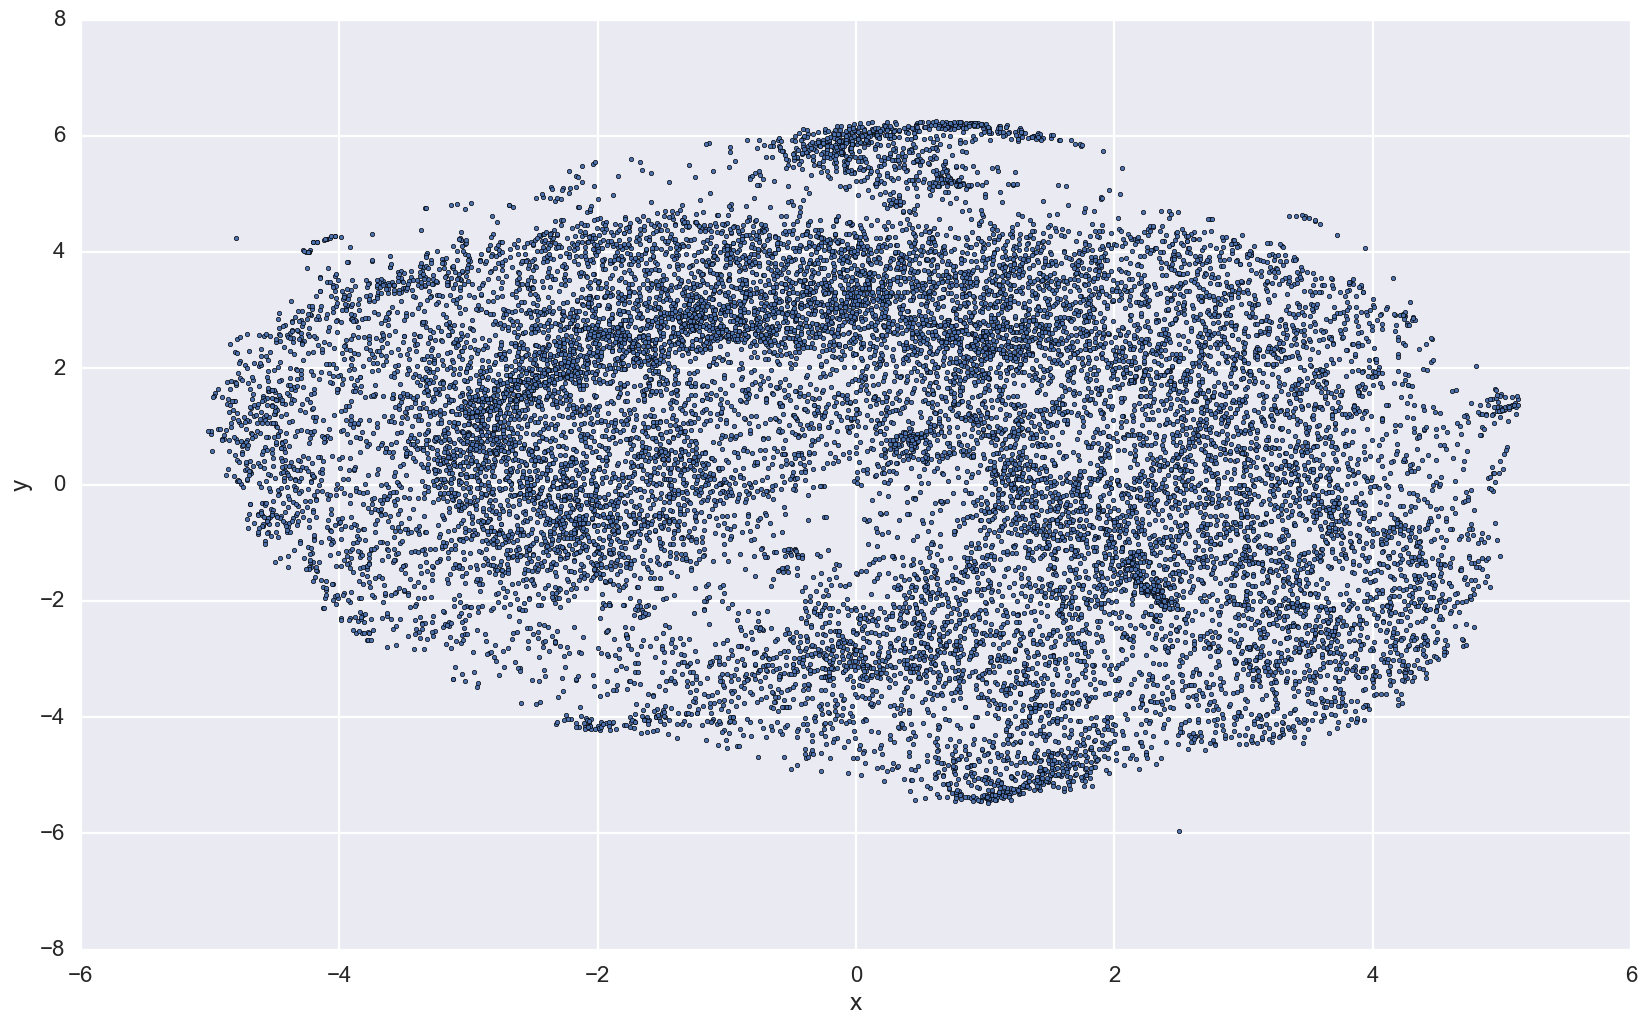

In [44]:
word_points.plot.scatter("x", "y", s=10, figsize=(20, 12))

### A mystery function to zoom into specific areas
I have not quite understood how this one functions! Looked a bit, have to look more still.

In [46]:
# just checking...
import keyword
keyword.iskeyword("slice")

False

In [52]:
def plot_region(x_bounds, y_bounds):
    slice = word_points[
        # TODO: find out what the <= operator does. Or this whole thing man!!
        (x_bounds[0] <= word_points.x) &
        (word_points.x <= x_bounds[1]) & 
        (y_bounds[0] <= word_points.y) &
        (word_points.y <= y_bounds[1])
    ]
    
    # this creates a scatterplot of the points and defines the size of the plot
    # I'll find out what the 's' stands for...
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    # nice! this part plots the related words next to the points
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

## Looking at relationship plots

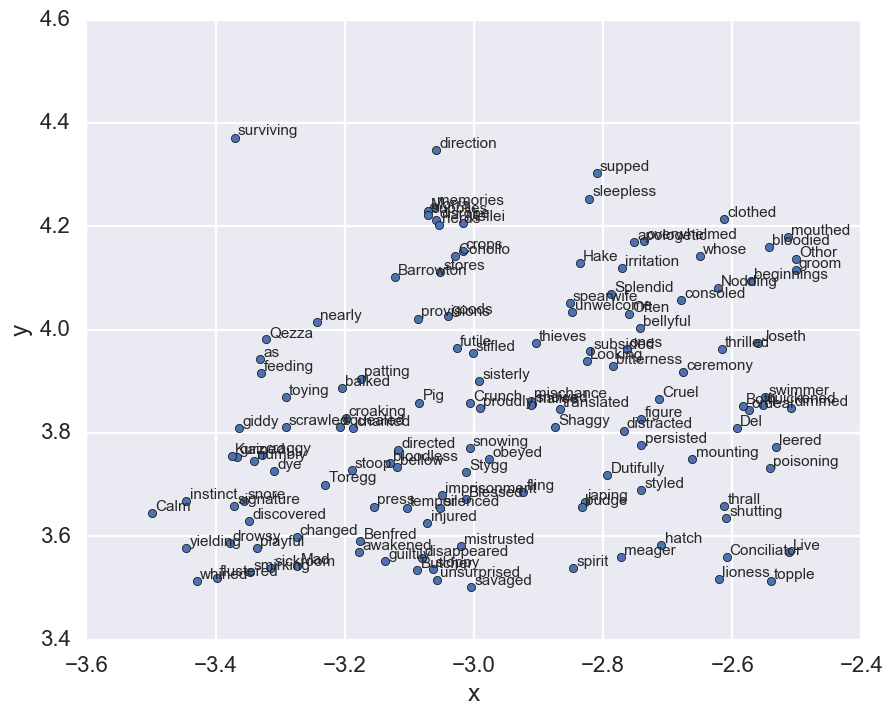

In [54]:
# plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))
plot_region(x_bounds=(-3.5, -2.5), y_bounds=(3.5, 4.5))

"surviving" seems to sit there pretty lonely...

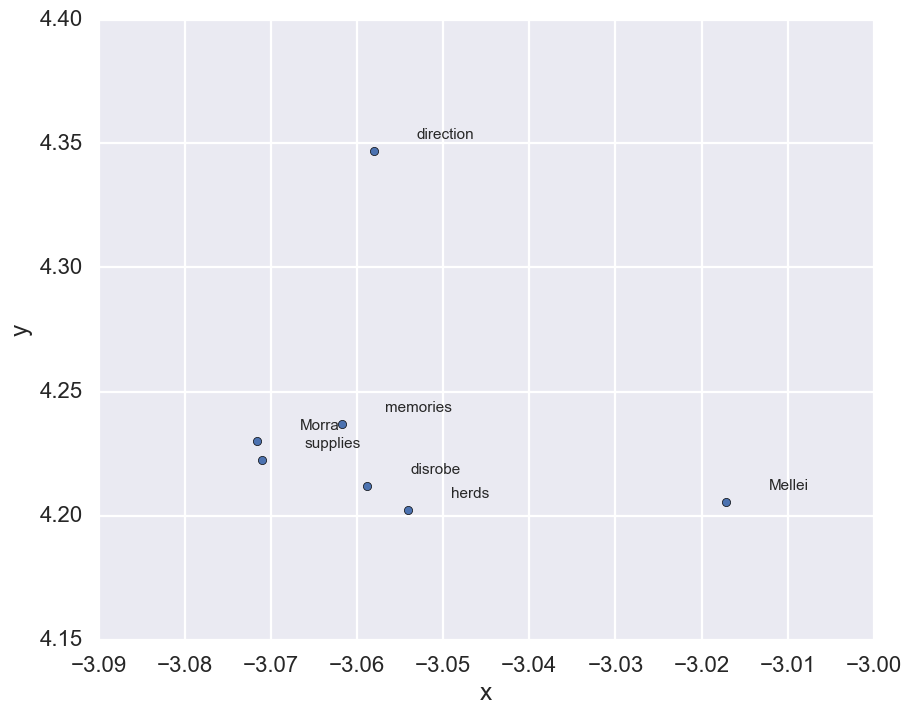

In [55]:
plot_region(x_bounds=(-3.2, -3.0), y_bounds=(4.2, 4.4))

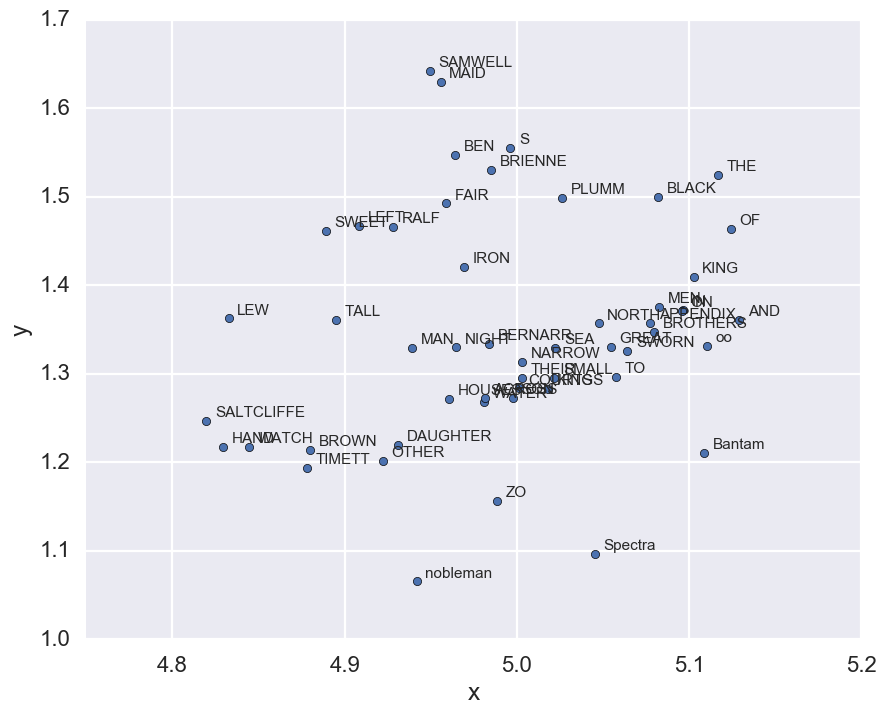

In [56]:
plot_region(x_bounds=(4.8, 5.2), y_bounds=(1.0, 1.8))

hm... I wonder whether the fact that these are capitalized makes a difference. I should have probably run a `.lower()` function on all the words.

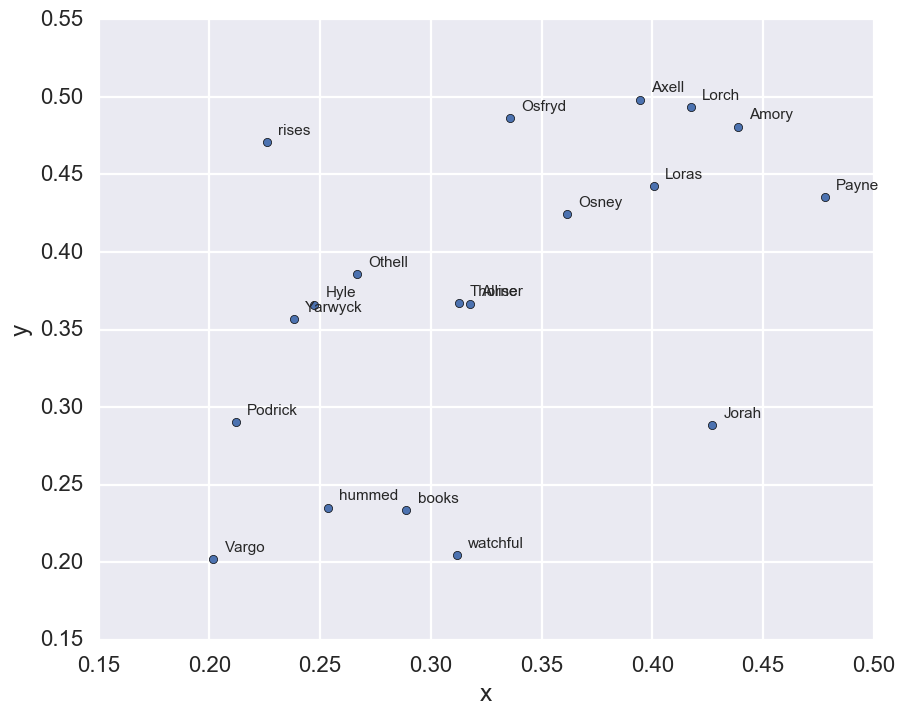

In [58]:
# okay, let's look at that lump right in the middle
plot_region(x_bounds=(0.2, 0.5), y_bounds=(0.2, 0.5))

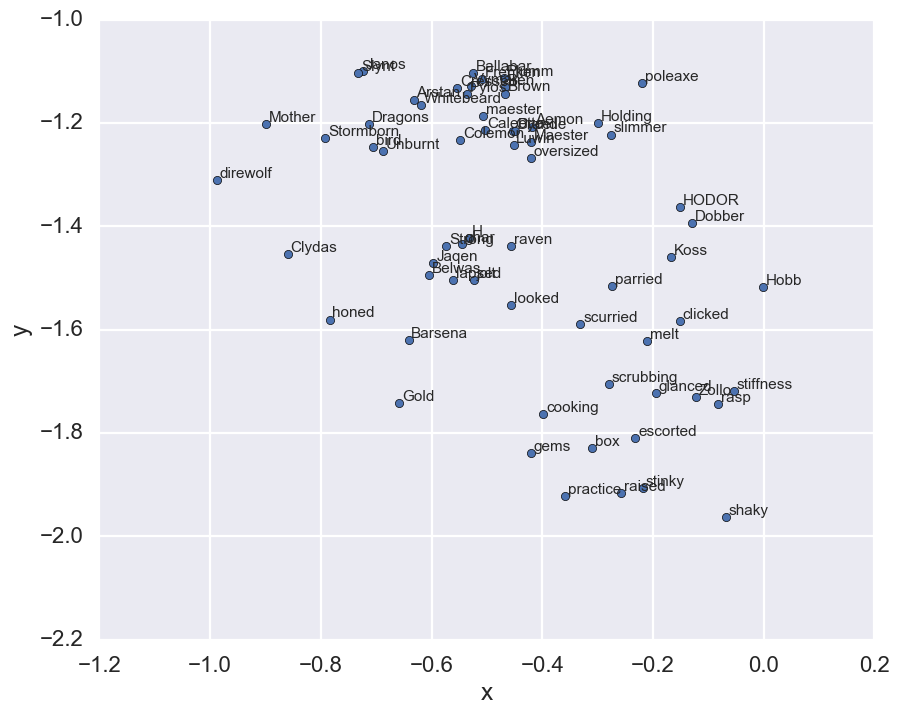

In [61]:
# not really finding all that interesting clusters... one more try.
plot_region(x_bounds=(-1.0, 0), y_bounds=(-2.0, -1.0))

Hm... At least I found HODOR(?). Pity that I don't actually know much of the story, to realize whether anything here makes sense.

## Exploring the similarities between characters
Let's start with the [Great Houses](http://gameofthrones.wikia.com/wiki/Great_House):

In [62]:
# returns the words that are closest to the given word
thrones2vec.most_similar("Stark")

[('Eddard', 0.7273167967796326),
 ('Lyanna', 0.6533306241035461),
 ('Winterfell', 0.6438389420509338),
 ('beheaded', 0.6372391581535339),
 ('Benjen', 0.6231783032417297),
 ('Robb', 0.6219102144241333),
 ('Rickard', 0.6194503307342529),
 ('executed', 0.6159437894821167),
 ('Tully', 0.6085497140884399),
 ('Hornwood', 0.6034160852432251)]

In [63]:
thrones2vec.most_similar("Aerys")

[('Mad', 0.793386697769165),
 ('Jaehaerys', 0.7771428823471069),
 ('Daeron', 0.7626447677612305),
 ('Rhaegar', 0.7391954064369202),
 ('Viserys', 0.7371395826339722),
 ('II', 0.7298679351806641),
 ('reign', 0.7264015674591064),
 ('Unworthy', 0.714614987373352),
 ('Conciliator', 0.7126691341400146),
 ('Targaryen', 0.7125906944274902)]

In [65]:
thrones2vec.most_similar("Arryn")

[('Lysa', 0.7288538217544556),
 ('widow', 0.7094741463661194),
 ('Eyrie', 0.7020829916000366),
 ('Alys', 0.7002462148666382),
 ('LYSA', 0.682256817817688),
 ('Connington', 0.6721274852752686),
 ('Lyanna', 0.6695934534072876),
 ('Vale', 0.6634308099746704),
 ('Sybell', 0.6619083881378174),
 ('Nestor', 0.6605349183082581)]

In [66]:
thrones2vec.most_similar("Greyjoy")

[('Turncloak', 0.6809372901916504),
 ('Theon', 0.6805459260940552),
 ('Balon', 0.6736826300621033),
 ('Chair', 0.665413498878479),
 ('Dagon', 0.6650172472000122),
 ('Asha', 0.6577829718589783),
 ('rebellion', 0.649343729019165),
 ('Rebellion', 0.648701012134552),
 ('Seastone', 0.6421291828155518),
 ('Victarion', 0.6315764784812927)]

In [67]:
thrones2vec.most_similar("Lannister")

[('pays', 0.6849679350852966),
 ('Tywin', 0.6557296514511108),
 ('Kevan', 0.6539247035980225),
 ('Jaime', 0.643532395362854),
 ('debts', 0.6422027945518494),
 ('Kingslayer', 0.6266014575958252),
 ('Cersei', 0.6121732592582703),
 ('Lancel', 0.5781788229942322),
 ('prisoner', 0.5682858228683472),
 ('lion', 0.5670099258422852)]

In [69]:
thrones2vec.most_similar("Tyrell")

[('Mace', 0.8083516955375671),
 ('Renly', 0.7055367827415466),
 ('Margaery', 0.7051625847816467),
 ('Loras', 0.6964934468269348),
 ('Garlan', 0.6948590278625488),
 ('Redwyne', 0.67498779296875),
 ('Highgarden', 0.671898365020752),
 ('support', 0.6564607620239258),
 ('Mathis', 0.6500663757324219),
 ('Alester', 0.6472867727279663)]

### Something about the wall and the North

In [72]:
thrones2vec.most_similar("white")

[('grey', 0.6958186626434326),
 ('silvery', 0.6714262962341309),
 ('snowy', 0.6706908941268921),
 ('draped', 0.6702133417129517),
 ('trimmed', 0.6700851917266846),
 ('sable', 0.6620854139328003),
 ('scale', 0.6602405309677124),
 ('rainbow', 0.6595703363418579),
 ('shiny', 0.6589341759681702),
 ('immaculate', 0.6502816677093506)]

In [73]:
thrones2vec.most_similar("Wall")

[('ranging', 0.6701107025146484),
 ('wildlings', 0.6501539945602417),
 ('Fist', 0.6497540473937988),
 ('Milkwater', 0.6432672142982483),
 ('Umbers', 0.6427651643753052),
 ('Frostfangs', 0.6381790637969971),
 ('Styr', 0.6316543221473694),
 ('mountains', 0.6244446039199829),
 ('Gift', 0.6226984262466431),
 ('Jarl', 0.6220771074295044)]

In [74]:
thrones2vec.most_similar("Night")

[('Watch', 0.9254637360572815),
 ('deserter', 0.6898921728134155),
 ('Magnar', 0.6698392629623413),
 ('skinchanger', 0.6542119979858398),
 ('Gift', 0.6518454551696777),
 ('Greywater', 0.6201688051223755),
 ('hunter', 0.6199442148208618),
 ('Commander', 0.6180785894393921),
 ('Gorold', 0.6152185201644897),
 ('Thenn', 0.6123949885368347)]

In [75]:
thrones2vec.most_similar("walkers")

[('lumps', 0.9037290811538696),
 ('invisible', 0.886345624923706),
 ('inhospitable', 0.878256618976593),
 ('camels', 0.8719290494918823),
 ('brilliant', 0.8718447685241699),
 ('savaging', 0.8695127964019775),
 ('lowering', 0.8688439726829529),
 ('husks', 0.867949366569519),
 ('horny', 0.8678910136222839),
 ('dusting', 0.8669027090072632)]

In [76]:
thrones2vec.most_similar("North")

[('East', 0.8136792182922363),
 ('Warden', 0.7966371178627014),
 ('West', 0.7750862240791321),
 ('Protector', 0.7718314528465271),
 ('Islands', 0.7645054459571838),
 ('Karhold', 0.7612775564193726),
 ('Torrhen', 0.7588091492652893),
 ('Knelt', 0.7585228085517883),
 ('Wolf', 0.7503963708877563),
 ('executed', 0.7484906315803528)]

Okay, because it comes up so much.

In [77]:
thrones2vec.most_similar("executed")

[('Edrick', 0.9029276371002197),
 ('reigns', 0.9026886224746704),
 ('bested', 0.9006123542785645),
 ('confirm', 0.8969178795814514),
 ('Daena', 0.8966610431671143),
 ('bestowed', 0.8945596814155579),
 ('declaring', 0.8938241004943848),
 ('shipped', 0.8921520113945007),
 ('absently', 0.8919638395309448),
 ('graces', 0.8911401033401489)]

In [78]:
thrones2vec.most_similar("beheaded")

[('executed', 0.8823572397232056),
 ('conspired', 0.866953432559967),
 ('presumed', 0.8668719530105591),
 ('conspiring', 0.8626348972320557),
 ('murdering', 0.8625966310501099),
 ('foster', 0.8605250716209412),
 ('strangled', 0.8568745851516724),
 ('grandson', 0.8542662858963013),
 ('Karhold', 0.8486574292182922),
 ('graces', 0.8468053340911865)]

Checking out this other thing.

### Linear relationships between word pairs

In [82]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("'{start1}' is related to '{end1}', as '{start2}' is related to '{end2}'".format(**locals()))
    return start2

In [90]:
nearest_similarity_cosmul("white", "walkers", "North")
nearest_similarity_cosmul("dragons", "fire", "water")
nearest_similarity_cosmul("beheaded", "Stark", "Lannister")

'white' is related to 'walkers', as 'Sunspear' is related to 'North'
'dragons' is related to 'fire', as 'ships' is related to 'water'
'beheaded' is related to 'Stark', as 'pays' is related to 'Lannister'


'pays'

That's enough for me for now. I think I should rather work with a book corpus that I actually read or know about. That might be more rewarding. Although it's kind of interesting to "read" a novel through the eyes of analysis.